In [1]:
import DMeRates
import DMeRates.DMeRate as DMeRate
import numericalunits as nu
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
mX_array = np.concatenate((np.arange(0.2,0.8,0.025),np.array([0.9]),np.arange(1,5,0.05),np.arange(5,11,1),np.array([20,50,100,200,500,1000,10000]))) #MeV
FDMn = 2

halo_model = 'shm'
DoScreen = False
test_mX = 10 #MeV
test_mX_eV = test_mX*1e6
test_mX_unitized= test_mX * nu.MeV / nu.c0**2
ne = 1
cs = 1e-36
cs_unitized = cs * nu.cm**2

In [29]:
from DMeRates.Constants import *
from DMeRates.form_factor import form_factor

si_ff = form_factor('QCDark/results/Si_final.hdf5')
import torch
from torchquad import Simpson,set_up_backend
set_up_backend('torch')

n = 0

def tfscreening(E, q):
    """Transfer function with screening effects - properly vectorized"""
    # Convert units
    E_eV = E / nu.eV
    q_eV = q / (nu.eV / nu.c0)
    
    # Get material parameters
    tfdict = tf_screening['Si']
    eps0, qTF, omegaP, alphaS = tfdict['eps0'], tfdict['qTF'], tfdict['omegaP'], tfdict['alphaS']
    omegaP_eV = omegaP / nu.eV
    qTF_eV = qTF / nu.eV
    mElectron_eV = me_eV / nu.eV

    # Compute result with proper broadcasting
    result = alphaS * ((q_eV / qTF_eV)**2)
    result = result + 1.0 / (eps0 - 1)
    result = result + q_eV**4 / (4. * (mElectron_eV**2) * (omegaP_eV**2))
    
    # Ensure proper broadcasting for E term
    E_term = (E_eV / omegaP_eV)**2
    if E_term.dim() < result.dim():
        E_term = E_term.expand_as(result)
    result = result - E_term
    
    return 1. / (1. + 1. / result)

def fdm(q,n):
    return (nu.alphaFS*  nu.me * nu.c0 /q)**n

def eta(vmin):
    return torch.ones_like(vmin)

def ff(E,q):
    return torch.ones_like(E) * torch.ones_like(q)
def drde(E_grid, q_grid, mX):
    """Compute differential rate with proper function-based integration"""
    integrator = Simpson()
    results = torch.zeros_like(E_grid)
    
    # Integration bounds
    q_min = float(q_grid.min())
    q_max = float(q_grid.max())
    
    for i, E in enumerate(E_grid):
        # Define the integrand as a function of q for this specific E
        def integrand(q):
            q_tensor = torch.tensor(q, device=E_grid.device).unsqueeze(-1)
            vmin = (E / q_tensor) + (q_tensor / (2 * mX))
            return (eta(vmin) * ff(E, q_tensor) * 
                   tfscreening(E, q_tensor) * 
                   fdm(q_tensor, n) * 
                   (1. / q_tensor**2)).squeeze()
        
        # Perform the integration
        integral = integrator.integrate(
            integrand,
            dim=1,
            N=len(q_grid),  # Number of evaluation points
            integration_domain=[[q_min, q_max]]
        )
        results[i] = integral
    
    return results / E_grid
    

mX = 1 * nu.MeV / nu.c0**2
Earr = torch.arange(500) * si_ff.dE 
qArr = torch.arange(1,1251) * si_ff.dq 



Using form factor calculated from file: QCDark/results/Si_final.hdf5


In [31]:
drderes = drde(Earr,qArr,mX)
drderes.shape

c:\Users\Ansh\Projects\DarkMatterRates\.conda\Lib\site-packages\torchquad\integration\simpson.py:76: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1250 -> 1249.
  warnings.warn(
C:\Users\Ansh\AppData\Local\Temp\ipykernel_32564\379922880.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_tensor = torch.tensor(q, device=E_grid.device).unsqueeze(-1)
c:\Users\Ansh\Projects\DarkMatterRates\.conda\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


torch.Size([500])

In [3]:
from QCDark.dark_matter_rates import d_rate,default_screening,default_si,read_output,default_astro
from QCDark.dark_matter_rates import form_factor as qcdark_form_factor



if DoScreen:
    screening = default_si
else:
    screening = default_screening
cff = read_output('QCDark/results/Si_final.hdf5')
Ee_old, dR_old= d_rate(test_mX_eV, cff, FDM_exp = FDMn, screening = screening, astro_model = default_astro)


from QEDark.QEDark2 import QEDark
qedark = QEDark()
Ee_qe = torch.arange(0,50,0.1)
drde_qedark = qedark.vectorized_dRdE('Si',test_mX_eV,Ee_qe,FDMn,'imb',DoScreen=DoScreen)


import DMeRates
import DMeRates.DMeRate
dmrates = DMeRate.DMeRate('Si',QEDark=False)
dmrates_qedark = DMeRate.DMeRate('Si',QEDark=True)


drde_qcdark_redo_res = dmrates.vectorized_dRdE(test_mX,FDMn,halo_model,DoScreen=DoScreen,integrate=True,unitize=True,debug=True) 
drde_qedark_redo = dmrates_qedark.vectorized_dRdE(test_mX,FDMn,'imb',DoScreen=DoScreen,integrate=False,unitize=True,debug=False)
drde_qcdark_redo = dmrates.vectorized_dRdE(test_mX,FDMn,halo_model,DoScreen=DoScreen,integrate=True,unitize=True,debug=False) 



Using form factor calculated from file: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../QCDark/results/Si_final.hdf5


/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torchquad/integration/simpson.py:76: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1250 -> 1249.
  warnings.warn(
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **

RuntimeError: The size of tensor a (500) must match the size of tensor b (1249) at non-singleton dimension 1

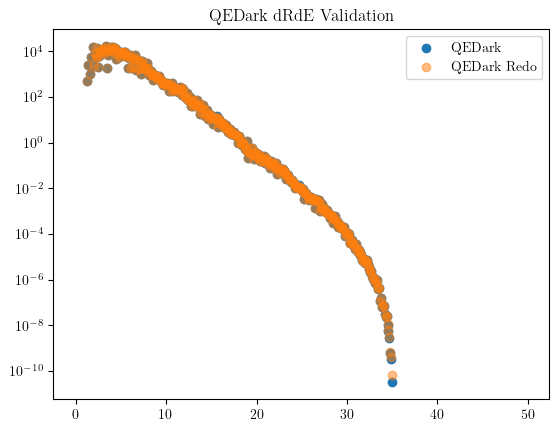

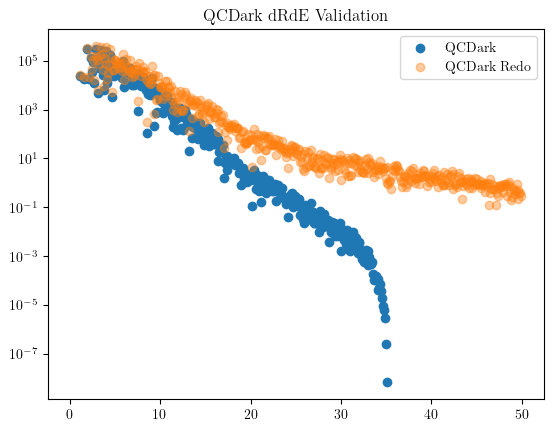

In [ ]:
plt.scatter(Ee_qe,drde_qedark,label='QEDark')
plt.scatter(dmrates_qedark.Earr/nu.eV,drde_qedark_redo,label='QEDark Redo',alpha=0.5)
plt.yscale('log')
plt.legend()
plt.title('QEDark dRdE Validation')
plt.show()
plt.close()

plt.scatter(Ee_old,dR_old,label='QCDark')
plt.scatter(dmrates.Earr/nu.eV,drde_qcdark_redo,label='QCDark Redo',alpha=0.4)
plt.yscale('log')
plt.legend()
plt.title('QCDark dRdE Validation')
plt.show()
plt.close()


In [5]:
# from QCDark.dark_matter_rates import d_rate_FanoQ,d_rate_RamanathanQ

# ionizationFile = 'DMeRates/p100k.dat'
# ionization_model = 'R'

# Si_ff = qcdark_form_factor('QCDark/results/Si_final.hdf5')
# from QEDark.QEDark2 import QEDark
# qedark = QEDark()
# qedark_step= QEDark()
# qedark_step.change_to_step()

# qcdark_results = []
# qedark_results = []
# qcdark_results_step = []
# nes = [1,2,3,4,5,6,7,8,9,10]
# qedark_results_step = []

# for mX in mX_array: #MeV
#     qcdarkeresult = d_rate_RamanathanQ(mX*1e6, Si_ff, ionizationFile, FDM_exp = FDMn, screening = screening, astro_model = default_astro)
#     qcdarkeresult = qcdarkeresult[1][ne]
#     qcdark_results.append(qcdarkeresult)

#     qcdarkeresultstep = d_rate_FanoQ(mX*1e6, Si_ff, 3.8, FDM_exp = FDMn, screening = screening, astro_model = default_astro)
#     qcdarkeresultstep = qcdarkeresultstep[1][ne]
#     qcdark_results_step.append(qcdarkeresultstep)


#     qedarkresult = qedark.vectorized_dRdnE('Si',mX,nes,FDMn,'imb',DoScreen=DoScreen)[ne-1]
#     qedark_results.append(float(qedarkresult))
#     qedarkresultstep = qedark_step.vectorized_dRdnE('Si',mX,nes,FDMn,'imb',DoScreen=DoScreen)[ne-1]
#     qedark_results_step.append(float(qedarkresultstep))

# qedark_results = np.array(qedark_results)
# qcdark_results = np.array(qcdark_results)
# qedark_results_step = np.array(qedark_results_step)
# qcdark_results_step = np.array(qcdark_results_step)



In [6]:
# import DMeRates
# import DMeRates.DMeRate as DMeRate
# dmrates = DMeRate.DMeRate('Si',QEDark=False)
# dmrates_qedark = DMeRate.DMeRate('Si',QEDark=True)

# qcdark_redo = dmrates.calculate_rates(mX_array,'shm',FDMn,ne=nes,integrate=True,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year
# qedark_redo = dmrates_qedark.calculate_rates(mX_array,'imb',FDMn,ne=nes,integrate=False,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year


# dmrates_qedark.change_to_step()
# dmrates.change_to_step()

# qcdark_redo_step = dmrates.calculate_rates(mX_array,'shm',FDMn,ne=nes,integrate=True,DoScreen=DoScreen) *nu.kg*nu.year
# qedark_redo_step = dmrates_qedark.calculate_rates(mX_array,'imb',FDMn,ne=nes,integrate=False,DoScreen=DoScreen)[ne-1] *nu.kg*nu.year





In [7]:
# plt.plot(mX_array,qedark_results,label='QEDark')
# plt.plot(mX_array,qcdark_results,label='QCDark')
# plt.plot(mX_array,qedark_redo,label='QEDark Redo',ls='--')
# plt.plot(mX_array,qcdark_redo,label='QCDark Redo',ls='--')

# plt.legend()
# plt.xscale('log')
# # plt.yscale('log')

# plt.show()
# plt.close()

In [8]:
# plt.plot(mX_array,qedark_results_step,label='QEDark')
# plt.plot(mX_array,qcdark_results_step,label='QCDark')
# plt.plot(mX_array,qedark_redo_step,label='QEDark Redo',ls='--')
# plt.plot(mX_array,qcdark_redo_step,label='QCDark Redo',ls='--')

# plt.legend()
# plt.xscale('log')
# # plt.yscale('log')

# plt.show()
# plt.close()

In [ ]:
#this is for testing wimprates
import DMeRates
import DMeRates.DMeRate as DMeRate
material = 'Xe'
dmrates = DMeRate.DMeRate(material)
import numpy as np

import numericalunits as nu
from DMeRates.Constants import *


In [21]:
test_shell = '5p'
test_mX = 1000
test_mX_unitized = test_mX * nu.MeV / nu.c0**2
test_mX_eV = 1000*1e6

test_cs = 4e-34
FDMn = 2
halo_model = 'shm'

dmrates.update_crosssection(test_cs)
drs = dmrates.noble_dRdE(test_mX,FDMn,halo_model,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,unitize=True)


In [22]:
dr_5p_res = dmrates.rate_dme_shell(test_mX_unitized,FDMn,halo_model,test_shell,unitize=True,debug=True)

tensor([[0.0000e+00, 5.7415e-15]])
returning debug output:
integrated_result,prefactor,fdm_factor,ff_arr,etas,qArr,qmin,qmax


In [23]:
dr_5p_res[0]

tensor([7.0658e+03, 6.8600e+03, 6.6489e+03, 6.4360e+03, 6.2182e+03, 5.9957e+03,
        5.7724e+03, 5.5452e+03, 5.3177e+03, 5.0882e+03, 4.8562e+03, 4.6270e+03,
        4.3964e+03, 4.1682e+03, 3.9420e+03, 3.7163e+03, 3.4967e+03, 3.2791e+03,
        3.0672e+03, 2.8615e+03, 2.6599e+03, 2.4688e+03, 2.2832e+03, 2.1063e+03,
        1.9394e+03, 1.7796e+03, 1.6327e+03, 1.4941e+03, 1.3659e+03, 1.2493e+03,
        1.1406e+03, 1.0446e+03, 9.5658e+02, 8.7725e+02, 8.0699e+02, 7.4242e+02,
        6.8475e+02, 6.3060e+02, 5.8034e+02, 5.3010e+02, 4.8226e+02, 4.3245e+02,
        3.8298e+02, 3.3554e+02, 2.8712e+02, 2.4395e+02, 2.0343e+02, 1.6806e+02,
        1.3778e+02, 1.1157e+02, 8.9916e+01, 7.1795e+01, 5.6892e+01, 4.4742e+01,
        3.4838e+01, 2.6905e+01, 2.0578e+01, 1.5591e+01, 1.1689e+01, 8.6730e+00,
        6.3597e+00, 4.6073e+00, 3.2962e+00, 2.3284e+00, 1.6254e+00, 1.1223e+00,
        7.6852e-01, 5.2367e-01, 3.5662e-01, 2.4401e-01, 1.6849e-01, 1.1778e-01,
        8.3444e-02, 5.9788e-02, 4.3195e-

In [24]:
import sys
sys.path.append('wimprates_mod')
from wimprates_ansh import rate_dme,rate_dme_sum,dRdE,years_per_day,dRdne
erec = dmrates.Earr.numpy() / nu.eV
drs_old = dRdE(test_mX,test_cs,FDMn,e_er = None,isoangle = None,mat = material,useVerne = True,verbose=False,integrate=False)
# years_per_day


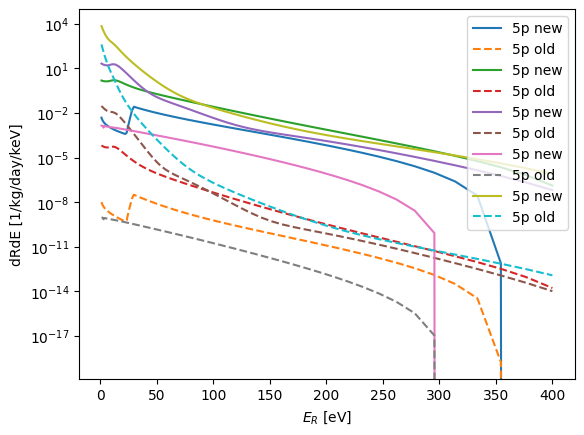

In [25]:
import matplotlib.pyplot as plt
import numericalunits as nu
for shell in dmrates.form_factor.keys:
    if shell in skip_keys[material]:
        continue
    plt.plot(erec,drs[shell],label=f"{test_shell} new")
    plt.plot(erec,drs_old[shell]*years_per_day,label=f"{test_shell} old",ls='--')

plt.yscale('log')
plt.xlabel('$E_R$ [eV]')
plt.legend()
plt.ylabel("dRdE [1/kg/day/keV]")
plt.show()
plt.close()


In [26]:
import torch
nes = torch.arange(1,17)
n_el, drsrates_old = dRdne(test_mX,test_cs,FDMn,e_er = None,isoangle=None,material='Xe',maxne = int(torch.max(nes)),ne='All',return_shells=True,useVerne=True,verbose=False,integrate=False)
n_el, drsn_old_sun = dRdne(test_mX,test_cs,FDMn,e_er = None,isoangle=None,material='Xe',maxne = int(torch.max(nes)),ne='All',return_shells=False,useVerne=True,verbose=False,integrate=False)
drsn_old_sun[1]

261115.6555741502

In [27]:
rates_new_allsum = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=False)

rates_new_all,shells = dmrates.calculate_nobleGas_rates(test_mX,halo_model,FDMn,nes,isoangle=None,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=True)
shells

['Summed', '4p', '4d', '5s', '4s', '5p']

In [28]:
rates_new_allsum * nu.tonne * nu.year

tensor([[7.8301e+06],
        [5.3738e+05],
        [5.5239e+04],
        [1.0611e+04],
        [7.3069e+03],
        [3.7863e+03],
        [1.5748e+03],
        [7.3080e+02],
        [3.8847e+02],
        [2.2853e+02],
        [1.2321e+02],
        [6.6602e+01],
        [3.8152e+01],
        [2.1696e+01],
        [1.2717e+01],
        [7.5104e+00]])

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/k8/_jhxw6sx2gj8wjzbhc789q540000gn/T/ipykernel_70651/4125883175.py:4: SyntaxWarning: invalid escape sequence '\c'
  title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}"
/var/folders/k8/_jhxw6sx2gj8wjzbhc789q540000gn/T/ipykernel_70651/4125883175.py:4: SyntaxWarning: invalid escape sequence '\s'
  title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}"


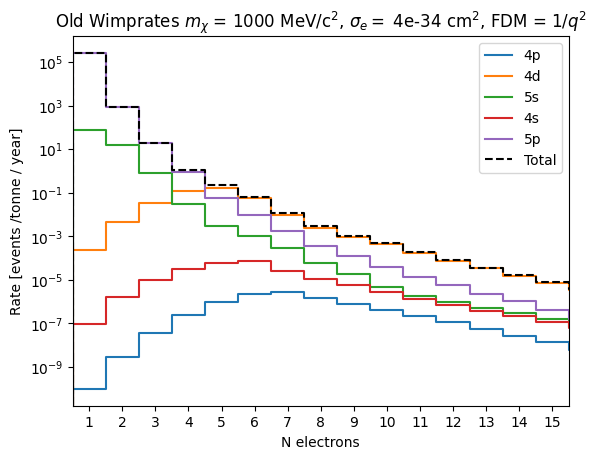

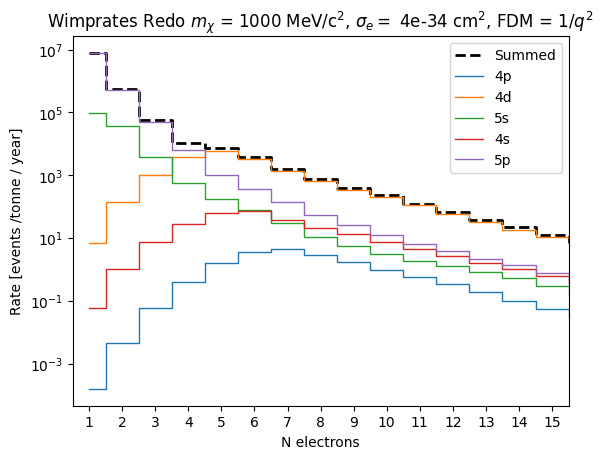

In [29]:
fdm_dict = {0: '1',
            2: '$1/q^2$'}
fdm_str = fdm_dict[FDMn]
title = f"$m_\chi$ = {test_mX} MeV/c$^2$, $\sigma_e =$ {test_cs} cm$^2$, FDM = {fdm_str}" 

plt.title('Old Wimprates '+title)# + (' -- SWAP 4s<->4p' if True else ''))
drsrates_old
for shell, rn in drsrates_old.items():
        plt.plot(n_el, np.array(rn), drawstyle='steps-mid', label=shell)
plt.plot(n_el, np.sum(np.array(list(drsrates_old.values())), axis=0),
            label='Total',
            drawstyle='steps-mid', 
            linestyle='--', 
            c='k')
plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")
plt.legend()
plt.yscale('log')
plt.ylabel(f"Rate [events /tonne / year]")
plt.show()
plt.close()

plt.title('Wimprates Redo ' + title)# + (' -- SWAP 4s<->4p' if True else ''))


for i,key in enumerate(shells):
        ls = '--' if i == 0 else None
        c = 'k' if i ==0 else None
        lw = 2 if i == 0 else 1
        r = rates_new_all[0][:,i] * nu.tonne * nu.year
        plt.plot(nes,r,drawstyle='steps-mid',label=key,ls=ls,c=c,lw=lw)
plt.xticks(np.arange(1, 16))
plt.xlim(0.5, 15.5)
plt.xlabel("N electrons")
plt.legend()
plt.yscale('log')
plt.ylabel(f"Rate [events /tonne / year]")

plt.show()
plt.close()

In [1]:
dmrates.update_crosssection(1e-34)
kgyear= dmrates.calculate_nobleGas_rates(10.,'modulated',0,1,isoangle=i,halo_id_params=None,useVerne=False,calcErrors=None,debug=False,returnShells=False) * nu.kg * nu.year
kgyear

NameError: name 'dmrates' is not defined

In [1]:
import DMeRates
import DMeRates.DMeRate as DMeRate

import numpy as np

import numericalunits as nu

material = 'Xe'
dmrates = DMeRate.DMeRate(material)
test_mX = 1000.
test_mX_unitized = test_mX * nu.MeV / nu.c0**2
test_mX_eV = 1000*1e6

test_cs = 1e-40
FDMn = 0
halo_model = 'shm'
dmrates.update_crosssection(test_cs)
result= dmrates.calculate_rates(test_mX,halo_model,FDMn,1)
result * nu.kg*nu.day

/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[nan]], dtype=torch.float32)

In [2]:
import torch
import DMeRates
import DMeRates.DMeRate as DMeRate

import numpy as np

import numericalunits as nu

material = 'Si'
dmrates = DMeRate.DMeRate(material)
test_mX = 0.6
test_mX_unitized = test_mX* nu.MeV / nu.c0**2
test_cs = 1e-29
FDMn = 2
dmrates.update_crosssection(test_cs)
result1= dmrates.calculate_rates(test_mX,'shm',FDMn,ne=1)* nu.kg*nu.day
result2= dmrates.calculate_rates(test_mX,'modulated',FDMn,ne=1,isoangle=1,useVerne=True)* nu.kg*nu.day


vhigh = 3*(dmrates.vEarth + dmrates.vEscape)
vMins = torch.linspace(200,800,1000)

vMins_units= vMins / (nu.km / nu.s)

result1,result2,(result2-result1) / 2



/Users/ansh/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torchquad/integration/simpson.py:76: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1250 -> 1249.
  warnings.warn(


Using form factor calculated from file: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../QCDark/results/Si_final.hdf5
Using Halo Data from: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../halo_data/modulated/Verne_LM/mDM_0_6_MeV_sigmaE_1e-29_cm2/DM_Eta_theta_1.txt


(tensor([[100891.9982]]), tensor([[1.0228]]), tensor([[-50445.4877]]))

In [3]:
(dmrates.vEarth + dmrates.vEscape) / (nu.km / nu.s)

794.1999999999999

In [4]:
etashm_param = dmrates.get_parametrized_eta(vMins,test_mX_unitized,FDMn,'shm') *nu.year
etashm = dmrates.get_halo_data(vMins,test_mX_unitized,FDMn,'shm')/ (nu.s / nu.km)

In [5]:
# vMins = dmrates.vMin_tensor(dmrates.qArr,dmrates.Earr,test_mX_unitized) 
etas_mod = dmrates.get_halo_data(vMins,test_mX_unitized,FDMn,'modulated',isoangle=0) / (nu.s / nu.km)

etas_mod_param = dmrates.get_parametrized_eta(vMins,test_mX_unitized,FDMn,'modulated',isoangle=0) *nu.year


Using Halo Data from: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../halo_data/modulated/Parameter_Scan_LM/mDM_0_6_MeV_sigmaE_1e-29_cm2/DM_Eta_theta_0.txt
Using Halo Data from: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../halo_data/modulated/Parameter_Scan_LM/mDM_0_6_MeV_sigmaE_1e-29_cm2/DM_Eta_theta_0.txt


In [6]:
drde_shm_res = dmrates.vectorized_dRdE(test_mX,FDMn,'shm',DoScreen=True,integrate=True,unitize=False,debug=True) 
drde_mod_res = dmrates.vectorized_dRdE(test_mX,FDMn,'modulated',DoScreen=True,integrate=True,unitize=False,debug=True,isoangle=0) 

drde_shm = drde_shm_res[0]
drde_mod = drde_mod_res[0]
Earr = dmrates.Earr /nu.eV

Returning:
band_gap_result,result,etas,prefactor,fdm_factor,ff_arr,tf_factor,qdenom
Using Halo Data from: /Users/ansh/Local/SENSEI/DarkMatterRates/DMeRates/../halo_data/modulated/Parameter_Scan_LM/mDM_0_6_MeV_sigmaE_1e-29_cm2/DM_Eta_theta_0.txt
Returning:
band_gap_result,result,etas,prefactor,fdm_factor,ff_arr,tf_factor,qdenom


In [7]:
print(drde_shm_res[3] == drde_mod_res[3])
print(torch.sum(drde_shm_res[4] != drde_mod_res[4]))
print(torch.sum(drde_shm_res[5] != drde_mod_res[5]))
print(torch.sum(drde_shm_res[6] != drde_mod_res[6]))
print(torch.sum(drde_shm_res[7] != drde_mod_res[7]))

True
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [9]:
vmin_tensor = dmrates.vMin_tensor(dmrates.qArr,dmrates.Earr,test_mX_unitized) / (nu.km / nu.s)
test_old = np.array([122.6371329 , 126.97566851, 128.50763488, 139.0186085 ,
       152.02829761, 161.94131691, 166.53721602, 182.01622397,
       198.15897741, 214.77583475, 231.74311673, 248.97672143,
       266.41746602, 284.02249398, 301.76000851, 319.60592117,
       337.5416494 , 355.55262852, 373.62728148, 391.75629014,
       409.93207   , 411.29675483, 428.14838489, 446.40006012,
       464.68276587, 482.99285148, 501.32721734, 519.6832147 ,
       538.05856656, 556.45130467, 574.85971889, 593.28231628,
       611.71778761, 630.16498   , 648.62287421, 667.09056588,
       685.56724973, 704.05220639, 722.54479121, 741.04442486,
       759.55058519])

In [10]:
vmin_tensor = dmrates.vMin_tensor(dmrates.qArr,dmrates.Earr,test_mX_unitized) / (nu.km / nu.s)
np.sort(vmin_tensor[0,:41]) / test_old

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

torch.Size([500, 1250])


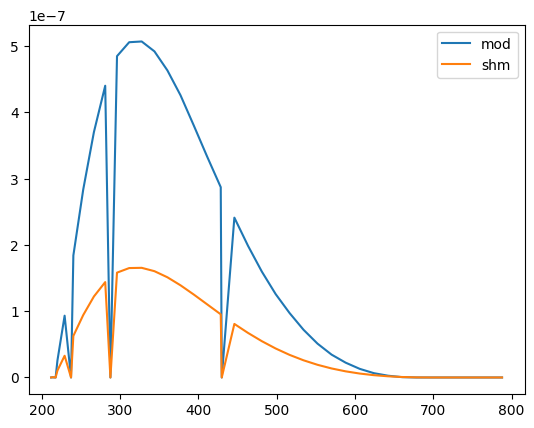

In [11]:
import matplotlib.pyplot as plt
etashm_tensor = drde_shm_res[2] * nu.year
etamod_tensor = drde_mod_res[2]* nu.year
ratio = etamod_tensor / etashm_tensor
print(ratio.shape)
index = 10
test_eta_mod = etamod_tensor[index,:]
test_eta_shm = etashm_tensor[index,:]
test_vmin = vmin_tensor[1,:]
indices = test_vmin < (800)
test_vmin = test_vmin[indices]
test_eta_mod = test_eta_mod[indices]
test_eta_shm = test_eta_shm[indices]
test_eta_mod = test_eta_mod[np.argsort(test_vmin)]
test_eta_shm = test_eta_shm[np.argsort(test_vmin)]
test_vmin = np.sort(test_vmin)

plt.plot(test_vmin,test_eta_mod,label='mod')
plt.plot(test_vmin,test_eta_shm,label='shm')
plt.legend()
plt.show()
plt.close()

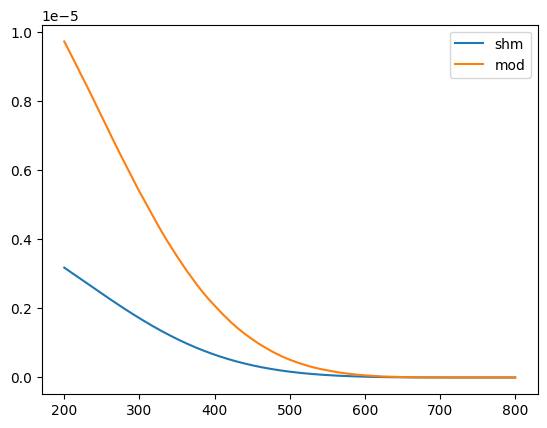

In [24]:
plt.plot(vMins,etashm_param,label='shm')
plt.plot(vMins,etas_mod_param,label='mod')

plt.legend()
plt.show()
plt.close()

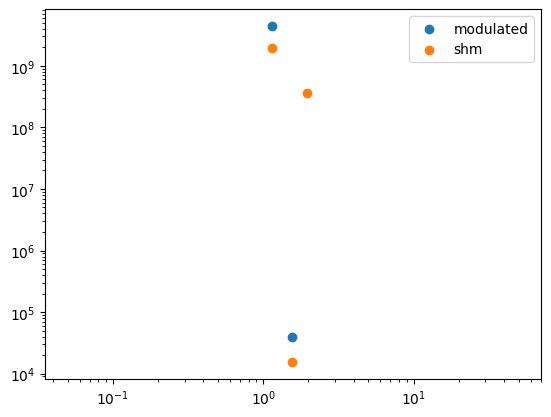

In [36]:
import matplotlib.pyplot as plt

plt.scatter(Earr,drde_mod * nu.kg * nu.year*nu.eV,label='modulated')
plt.scatter(Earr,drde_shm* nu.kg * nu.year*nu.eV,label='shm')
plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.show()
plt.close()

In [34]:
drdemod_unit = drde_mod[drde_mod >0]* nu.kg * nu.year*nu.eV
np.where(drde_mod > 0),drdemod_unit

((array([11, 15]),), tensor([4.4538e+09, 3.9879e+04]))

In [35]:
drdeshm_unit = drde_shm[drde_shm >0]* nu.kg * nu.year*nu.eV
np.where(drde_shm > 0),drdeshm_unit

((array([11, 15, 19]),), tensor([1.9817e+09, 1.5548e+04, 3.6850e+08]))

In [ ]:
dRdne = torch.trapezoid(dRdE*prob_fn_tiled,x=self.Earr, axis = 1)

In [25]:
prob_fn = torch.zeros_like(drde_mod)
prob_fn[12:50] = 1
modint = torch.trapezoid(drde_mod*prob_fn,x=dmrates.Earr) * nu.kg * nu.day
modint

tensor(10.9182)

In [26]:
shmint = torch.trapezoid(drde_shm*prob_fn,x=dmrates.Earr) * nu.kg * nu.day
shmint


tensor(100892.9905)

In [53]:
shmint  / modint

tensor(9240.8031)